<a href="https://colab.research.google.com/github/behdad13/time-series-forecasting/blob/main/CNN_LSTM_C_BO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## importing necessary libraries 

In [1]:
#installing necessary libraries
!pip install torch
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 34.3 MB/s 
     |████████████████████████████████| 81 kB 10.6 MB/s 
     |████████████████████████████████| 210 kB 81.3 MB/s 
     |████████████████████████████████| 78 kB 8.5 MB/s 
     |████████████████████████████████| 147 kB 75.2 MB/s 
     |████████████████████████████████| 50 kB 7.8 MB/s 
     |████████████████████████████████| 112 kB 73.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=dbffb525be1568ac25b6ad63d097e350bb4f78818698b426330b0dd08f1e18d5
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.1.0
    Unin

In [2]:
#import necessary libraries
import os
import random
import time
import pandas as pd
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from numpy import array
from sklearn.preprocessing import MinMaxScaler
import optuna
from optuna.trial import TrialState
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.nn.functional as F
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
#set seed
seed_val = 67
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## importing pre-processed dataset

In [4]:
#import the dataset
data = pd.read_csv('Data_Toronto.csv', low_memory=False)

#select the most relevent feature from the dataset
data = data[['Year', 'Month', 'Day', 'Hour', 'week_end','temperature', 'humidex', 'Ontario_Real_price', 'Electricity_Load']]

In [5]:
#define the test and train set
seq = 5*24
horizon = 24
train = data.iloc[17520+8760+8786 - seq : 43824 + horizon]
test = data.iloc[43824 - seq : 43824+30*24 + horizon]

## train-val-test split

In [6]:
#defining the training proportion
#seperating train and validation set
train_size = int(len(data)*0.80)      
valid_size = int(len(data)*0.20)
df_train, df_val = data[:train_size], data[train_size+1:]
df_train.shape, df_val.shape, test.shape

((38534, 9), (9633, 9), (864, 9))

In [7]:
# scaling each features of the dataset
scaler = MinMaxScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train),index = df_train.index, columns = df_train.columns)
df_val = pd.DataFrame(scaler.transform(df_val),index = df_val.index, columns = df_val.columns)
test = pd.DataFrame(scaler.transform(test),index = test.index, columns = test.columns)

## Make a time sequneces

In [8]:
df_train = df_train.to_numpy()
df_val = df_val.to_numpy()
test = test.to_numpy()

In [9]:
# split a multivariate sequence into samples
from numpy import array
def split_sequences(sequences, n_steps, for_hor):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-for_hor:
            break
        # gather input and output parts of the pattern
        # sequence_x ranges from 0 to seq_len and all columns except the last one.
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:end_ix+for_hor, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [10]:
n_timesteps = 24*5
for_hor = 24
X_train, y_train = split_sequences(df_train, n_timesteps, for_hor)
X_val, y_val = split_sequences(df_val, n_timesteps, for_hor)
X_test, y_test = split_sequences(test, n_timesteps, for_hor)

In [11]:
print(X_test.shape, y_test.shape)

(721, 120, 9) (721, 24)


In [12]:
n_timesteps + len(X_train) + for_hor-1 == len(df_train)

True

 ## Data Loader

In [13]:
from torch.utils.data import TensorDataset, DataLoader
import torch

batch_size = 64


X_train_t = torch.Tensor(X_train)
y_train_t = torch.Tensor(y_train)
X_val_t = torch.Tensor(X_val)
y_val_t = torch.Tensor(y_val)
X_test_t = torch.Tensor(X_test)
y_test_t = torch.Tensor(y_test)

train = TensorDataset(X_train_t, y_train_t)
val = TensorDataset(X_val_t, y_val_t)
test_w1 = TensorDataset(X_test_t, y_test_t)


train_loader = DataLoader(train, batch_size=batch_size, shuffle = True, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle = False, drop_last=True)
test_loader_one_w1 = DataLoader(test_w1, batch_size=1, shuffle = False, drop_last=True)

In [14]:
#check the size of the train set
X_train_t.shape, y_train_t.shape

(torch.Size([38391, 120, 9]), torch.Size([38391, 24]))

In [15]:
#just for testing the size of the batch
next(iter(train_loader))[1].size(), next(iter(train_loader))[0].size()

(torch.Size([64, 24]), torch.Size([64, 120, 9]))

## deep learning model

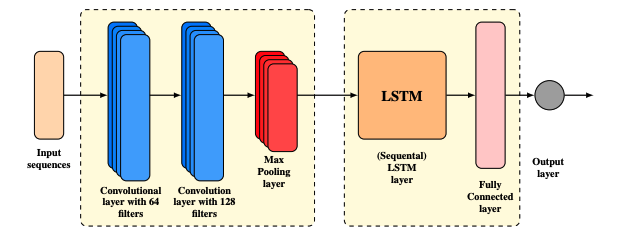

The following structure is based on the paper: https://link.springer.com/article/10.1007/s00521-020-04867-x

In [16]:
class CNNLSTM(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size1=9, kernel_size2=9, n_channels1=64, n_channels2=128, hidden_size= 256, pool_size=2,seq_len=72):
        super(CNNLSTM, self).__init__()
        
        self.conv1 = nn.Conv1d(input_dim, n_channels1, kernel_size=kernel_size1)     #the first convolution layer
        self.zp1 = nn.ConstantPad1d(((kernel_size1-1), 0), 0)                        #padding layer to conserve the initial form of the cnn output  

        self.conv2 = nn.Conv1d(n_channels1, n_channels2, kernel_size=kernel_size2)   #the second convolution layer
        self.zp2 = nn.ConstantPad1d(((kernel_size2-1), 0), 0)                        #padding layer to conserve the initial form of the cnn output  
        
        self.pool2 = nn.MaxPool1d(pool_size, stride=1)                               #the max pooling later 
        self.zp3 = nn.ConstantPad1d(((pool_size-1), 0), 0)                           #padding layer to conserve the initial form of the max pooling layer

        self.lstm = nn.LSTM(input_size=n_channels2, hidden_size=hidden_size)         #A LSTM layer 
        self.linear1 = nn.Linear(hidden_size*seq_len, output_dim)                    #Linear layer

    def forward(self, x):
        x = x.permute(0, 2, 1)

        y1 = self.zp1(x)
        y1 = torch.relu(self.conv1(y1))

        y1 = self.zp2(y1)
        y1 = torch.relu(self.conv2(y1))

        y1 = self.zp3(y1)
        y1 = self.pool2(y1)
        y1 = y1.permute(0, 2, 1) 

        y1, (_, _) = self.lstm(y1)
        out = torch.flatten(y1, start_dim=1)
        out = self.linear1(out)
        return out

In [17]:
x = torch.rand(64, 120, 9)

model = CNNLSTM(input_dim = 9, 
            output_dim=24, 
            kernel_size1=9, 
            n_channels1=32, 
            n_channels2=64, 
            pool_size=2,
            seq_len=24*5)

y= model(x)
y.shape

torch.Size([64, 24])

In [19]:
#defining an objective function of the bayesian Optimization and which parameters need to be tuned
epochs = 250 
patience = 20
loss = nn.MSELoss()
min_val_loss_total=np.inf

def objective(trial):
    #define the infinity variable
    min_val_loss = np.inf
    
    
    # Generate the model.
    model = CNNLSTM(input_dim = 9, 
                output_dim = 24, 
                kernel_size1 = trial.suggest_int("kernel_L1", 3, 10), 
                kernel_size2 = trial.suggest_int("kernel_L2", 3, 10),
                n_channels1 = trial.suggest_int("hidden_L1", 16, 128), 
                n_channels2 = trial.suggest_int("hidden_L2", 16, 128), 
                hidden_size = trial.suggest_int("hidden_lstm", 16, 128),
                pool_size = 2, #trial.suggest_int("pool_size", 2, 5),
                seq_len=24*5).cuda() 

    # Generate the optimizers.
    loss_fn = nn.MSELoss() 
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    # Training of the model.
    counter = 0
    for i in range(epochs):
        mse_train = 0
        iteration_start = time.monotonic()
        for batch_x, batch_y in train_loader :
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            opt.zero_grad()
            y_pred = model(batch_x)
            y_pred = y_pred.squeeze(1)
            l = loss(y_pred, batch_y)
            l.backward()
            mse_train += l.item()*batch_x.shape[0]
            opt.step()
        with torch.no_grad():
            mse_val = 0
            preds = []
            true = []
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.cuda()
                batch_y = batch_y.cuda()
                output = model(batch_x)
                output = output.squeeze(1)
                preds.append(output.detach().cpu().numpy())
                true.append(batch_y.detach().cpu().numpy())
                mse_val += loss(output, batch_y).item()*batch_x.shape[0]
        preds = np.concatenate(preds)
        true = np.concatenate(true)

        if min_val_loss > mse_val:
            min_val_loss = mse_val
            counter = 0
        else: 
            counter += 1
        if counter == patience:
            break   

        global min_val_loss_total
        if min_val_loss_total > mse_val:
            min_val_loss_total = mse_val
            torch.save(model.state_dict(), "CNNLSTMC.pt")


        if i % 20 == 0:
            print("Iter: ", i, "train: ", (mse_train), "val: ", (mse_val))
        
        if trial.should_prune():
            raise optuna.TrialPruned()
            
        trial.report(min_val_loss, i)

    return min_val_loss

In [20]:
if __name__ == "__main__":
    #create the study
    study = optuna.create_study(direction="minimize", 
                                sampler=optuna.samplers.TPESampler(), 
                                pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))

    #calling the optimzation process
    study.optimize(objective, n_trials=50)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    
    #with open("CNN.pickle".format(study.best_trial.number), "rb") as fin:
    #    best_clf = pickle.load(fin)

[I 2022-12-28 23:47:38,004] A new study created in memory with name: no-name-8095a44c-4cb9-446a-94cd-e88b9bd5efe5


Iter:  0 train:  244.85389848798513 val:  33.014539301395416
Iter:  20 train:  25.181912502273917 val:  35.53998131491244


[I 2022-12-28 23:49:21,389] Trial 0 finished with value: 25.403913689777255 and parameters: {'kernel_L1': 6, 'kernel_L2': 3, 'hidden_L1': 107, 'hidden_L2': 80, 'hidden_lstm': 101, 'lr': 0.00045419119717682744}. Best is trial 0 with value: 25.403913689777255.


Iter:  0 train:  629.8427496701479 val:  60.619145799428225
Iter:  20 train:  67.72416797280312 val:  25.503874441608787
Iter:  40 train:  54.71634689718485 val:  25.724038038402796
Iter:  60 train:  47.60931512340903 val:  24.107514915056527


[I 2022-12-28 23:52:44,501] Trial 1 finished with value: 22.826167732477188 and parameters: {'kernel_L1': 4, 'kernel_L2': 4, 'hidden_L1': 86, 'hidden_L2': 82, 'hidden_lstm': 38, 'lr': 3.7880163427616576e-05}. Best is trial 1 with value: 22.826167732477188.


Iter:  0 train:  1245.197713136673 val:  219.7533016204834
Iter:  20 train:  109.67784582823515 val:  36.716028267517686
Iter:  40 train:  89.73524445295334 val:  32.121465724892914
Iter:  60 train:  81.0909600481391 val:  29.704118742607534
Iter:  80 train:  75.79721004515886 val:  28.04181131720543
Iter:  100 train:  71.92752806097269 val:  26.841179745271802
Iter:  120 train:  69.19539375603199 val:  26.121988689526916
Iter:  140 train:  66.4672775939107 val:  25.62425914220512
Iter:  160 train:  64.44862977042794 val:  25.154493479058146
Iter:  180 train:  62.56562940776348 val:  24.403802521526814
Iter:  200 train:  61.09760024026036 val:  24.126437179744244
Iter:  220 train:  59.653565511107445 val:  24.13454189710319
Iter:  240 train:  58.36511743813753 val:  23.792617161758244


[I 2022-12-29 00:04:00,166] Trial 2 finished with value: 23.626372519880533 and parameters: {'kernel_L1': 7, 'kernel_L2': 6, 'hidden_L1': 19, 'hidden_L2': 72, 'hidden_lstm': 55, 'lr': 1.0818000647984145e-05}. Best is trial 1 with value: 22.826167732477188.


Iter:  0 train:  501.1630871742964 val:  48.74820799380541
Iter:  20 train:  58.952911879867315 val:  23.486801516264677
Iter:  40 train:  45.066881727427244 val:  24.76311950571835


[I 2022-12-29 00:06:32,430] Trial 3 finished with value: 23.111755652353168 and parameters: {'kernel_L1': 7, 'kernel_L2': 8, 'hidden_L1': 125, 'hidden_L2': 28, 'hidden_lstm': 30, 'lr': 8.584295196960008e-05}. Best is trial 1 with value: 22.826167732477188.


Iter:  0 train:  785.9097173213959 val:  72.95230935513973
Iter:  20 train:  71.91580260545015 val:  25.829478852450848
Iter:  40 train:  59.601112108677626 val:  23.74209589511156
Iter:  60 train:  52.104442059993744 val:  24.68810366280377


[I 2022-12-29 00:09:59,049] Trial 4 finished with value: 23.352005813270807 and parameters: {'kernel_L1': 3, 'kernel_L2': 3, 'hidden_L1': 93, 'hidden_L2': 86, 'hidden_lstm': 88, 'lr': 2.4999695237225797e-05}. Best is trial 1 with value: 22.826167732477188.


Iter:  0 train:  1108.7146571874619 val:  176.0952931046486


[I 2022-12-29 00:10:17,829] Trial 5 pruned. 


Iter:  0 train:  281.59660564363 val:  49.35877774655819
Iter:  20 train:  24.164939621463418 val:  34.02062372490764


[I 2022-12-29 00:12:23,582] Trial 6 pruned. 


Iter:  0 train:  783.489029198885 val:  91.16702120006084


[I 2022-12-29 00:12:45,111] Trial 7 pruned. 


Iter:  0 train:  395.91543611884117 val:  46.962546333670616
Iter:  20 train:  56.24191527813673 val:  25.46310087479651


[I 2022-12-29 00:14:40,914] Trial 8 pruned. 


Iter:  0 train:  944.5044181346893 val:  110.10359212756157


[I 2022-12-29 00:14:59,432] Trial 9 pruned. 


Iter:  0 train:  702.2649397850037 val:  66.74333707243204


[I 2022-12-29 00:15:18,364] Trial 10 pruned. 


Iter:  0 train:  618.0629200339317 val:  62.01666910201311


[I 2022-12-29 00:15:37,539] Trial 11 pruned. 


Iter:  0 train:  351.6578301638365 val:  50.79290218651295
Iter:  20 train:  48.40032399073243 val:  30.429548904299736


[I 2022-12-29 00:16:47,028] Trial 12 pruned. 


Iter:  0 train:  472.15898847579956 val:  53.09432163462043
Iter:  20 train:  51.14905095472932 val:  25.28766960836947


[I 2022-12-29 00:18:10,927] Trial 13 pruned. 


Iter:  0 train:  427.5879512876272 val:  61.37689704820514


[I 2022-12-29 00:18:47,500] Trial 14 pruned. 


Iter:  0 train:  268.15512681752443 val:  36.985640931874514
Iter:  20 train:  41.640032183378935 val:  26.03334891796112


[I 2022-12-29 00:20:34,843] Trial 15 finished with value: 23.412288488820195 and parameters: {'kernel_L1': 8, 'kernel_L2': 5, 'hidden_L1': 57, 'hidden_L2': 38, 'hidden_lstm': 70, 'lr': 0.0005479870904718975}. Best is trial 1 with value: 22.826167732477188.


Iter:  0 train:  595.4089796841145 val:  62.13981673121452


[I 2022-12-29 00:20:57,064] Trial 16 pruned. 


Iter:  0 train:  376.12132020294666 val:  45.33866260200739
Iter:  20 train:  43.32990071922541 val:  28.944407655857503


[I 2022-12-29 00:22:00,363] Trial 17 pruned. 


Iter:  0 train:  264.14652168005705 val:  32.98835890740156
Iter:  20 train:  40.37022006511688 val:  26.50516887009144


[I 2022-12-29 00:23:17,534] Trial 18 pruned. 


Iter:  0 train:  333.4601331949234 val:  38.451765812933445
Iter:  20 train:  34.300158239901066 val:  29.876239215955138


[I 2022-12-29 00:24:43,869] Trial 19 pruned. 


Iter:  0 train:  622.2123404294252 val:  63.32359542325139


[I 2022-12-29 00:25:04,084] Trial 20 pruned. 


Iter:  0 train:  778.6180117726326 val:  89.31318783760071


[I 2022-12-29 00:25:25,568] Trial 21 pruned. 


Iter:  0 train:  978.4300184845924 val:  110.0437668710947


[I 2022-12-29 00:25:45,650] Trial 22 pruned. 


Iter:  0 train:  591.3515497893095 val:  52.58522979542613


[I 2022-12-29 00:26:16,211] Trial 23 pruned. 


Iter:  0 train:  912.0712444186211 val:  121.7735945880413


[I 2022-12-29 00:26:39,193] Trial 24 pruned. 


Iter:  0 train:  429.27341613173485 val:  45.794813115149736


[I 2022-12-29 00:27:08,297] Trial 25 pruned. 


Iter:  0 train:  587.3646401464939 val:  53.58045873045921


[I 2022-12-29 00:27:30,362] Trial 26 pruned. 


Iter:  0 train:  1194.1756244897842 val:  181.32179287075996


[I 2022-12-29 00:27:50,126] Trial 27 pruned. 


Iter:  0 train:  342.61106364428997 val:  38.74445524811745
Iter:  20 train:  32.50337488949299 val:  32.20632437989116


[I 2022-12-29 00:29:18,568] Trial 28 pruned. 


Iter:  0 train:  285.2716107815504 val:  38.02862387150526
Iter:  20 train:  33.21125169098377 val:  28.81106963660568


[I 2022-12-29 00:30:44,482] Trial 29 finished with value: 23.408716641366482 and parameters: {'kernel_L1': 6, 'kernel_L2': 3, 'hidden_L1': 107, 'hidden_L2': 78, 'hidden_lstm': 41, 'lr': 0.00030156712434961885}. Best is trial 1 with value: 22.826167732477188.


Iter:  0 train:  384.78152272105217 val:  45.377659663558006
Iter:  20 train:  46.74861188977957 val:  24.325131613761187


[I 2022-12-29 00:33:18,894] Trial 30 finished with value: 23.591701785102487 and parameters: {'kernel_L1': 3, 'kernel_L2': 4, 'hidden_L1': 93, 'hidden_L2': 115, 'hidden_lstm': 111, 'lr': 7.908022087384968e-05}. Best is trial 1 with value: 22.826167732477188.


Iter:  0 train:  268.6256608888507 val:  33.75723687931895
Iter:  20 train:  30.286143627017736 val:  31.061197322793305


[I 2022-12-29 00:34:39,979] Trial 31 finished with value: 23.362849095836282 and parameters: {'kernel_L1': 6, 'kernel_L2': 3, 'hidden_L1': 105, 'hidden_L2': 96, 'hidden_lstm': 41, 'lr': 0.0003845191817422031}. Best is trial 1 with value: 22.826167732477188.


Iter:  0 train:  244.92490476369858 val:  37.728113919496536


[I 2022-12-29 00:35:31,712] Trial 32 pruned. 


Iter:  0 train:  240.22005862742662 val:  31.79500692896545


[I 2022-12-29 00:35:59,910] Trial 33 pruned. 


Iter:  0 train:  982.4543221592903 val:  122.58152386546135


[I 2022-12-29 00:36:19,017] Trial 34 pruned. 


Iter:  0 train:  1126.6092051267624 val:  172.52758267521858


[I 2022-12-29 00:36:40,218] Trial 35 pruned. 


Iter:  0 train:  320.7167467176914 val:  53.40746712312102


[I 2022-12-29 00:37:03,329] Trial 36 pruned. 


Iter:  0 train:  786.7521184682846 val:  107.93935391306877


[I 2022-12-29 00:37:23,697] Trial 37 pruned. 


Iter:  0 train:  557.3823089599609 val:  60.38374247774482


[I 2022-12-29 00:37:48,773] Trial 38 pruned. 


Iter:  0 train:  447.24162524938583 val:  63.76907350495458


[I 2022-12-29 00:38:07,939] Trial 39 pruned. 


Iter:  0 train:  1183.7572600841522 val:  225.92809683084488


[I 2022-12-29 00:38:26,594] Trial 40 pruned. 


Iter:  0 train:  297.9533153921366 val:  34.57487624138594


[I 2022-12-29 00:39:24,270] Trial 41 pruned. 


Iter:  0 train:  261.7555932402611 val:  38.9991161338985
Iter:  20 train:  26.08381948247552 val:  30.573963714763522


[I 2022-12-29 00:40:26,997] Trial 42 pruned. 


Iter:  0 train:  301.2903629243374 val:  35.98004320077598


[I 2022-12-29 00:41:18,557] Trial 43 pruned. 


Iter:  0 train:  306.2053595930338 val:  39.25626200437546


[I 2022-12-29 00:41:40,869] Trial 44 pruned. 


Iter:  0 train:  250.92637380212545 val:  35.6236975453794


[I 2022-12-29 00:42:08,334] Trial 45 pruned. 


Iter:  0 train:  436.8160911500454 val:  49.56393264234066


[I 2022-12-29 00:42:30,224] Trial 46 pruned. 


Iter:  0 train:  248.4146877899766 val:  34.636993028223515


[I 2022-12-29 00:43:05,046] Trial 47 pruned. 


Iter:  0 train:  214.84681598097086 val:  31.236427668482065


[I 2022-12-29 00:44:02,796] Trial 48 pruned. 


Iter:  0 train:  619.6720910966396 val:  61.509874776005745


[I 2022-12-29 00:44:21,718] Trial 49 pruned. 


Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  41
  Number of complete trials:  9
Best trial:
  Value:  22.826167732477188
  Params: 
    kernel_L1: 4
    kernel_L2: 4
    hidden_L1: 86
    hidden_L2: 82
    hidden_lstm: 38
    lr: 3.7880163427616576e-05


<ipython-input-21-d2271a8eb5c4>:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=["kernel_L1", "kernel_L2", 'hidden_L1',  'hidden_L2','hidden_lstm', "lr" ])


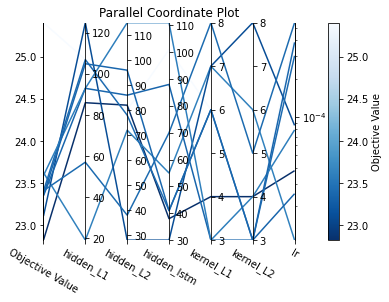

In [21]:
#Visualizing sets of tunned yperparameters based on the BO
optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=["kernel_L1", "kernel_L2", 'hidden_L1',  'hidden_L2','hidden_lstm', "lr" ])
optuna.visualization.plot_param_importances(study)

In [22]:
#Download the PT file
from google.colab import files
files.download('CNNLSTMC.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
#Read the pk file
model = CNNLSTM(input_dim = 9, 
                output_dim = 24, 
                kernel_size1 = 4, 
                kernel_size2 = 4,
                n_channels1 = 86, 
                n_channels2 = 82,
                hidden_size = 38,
                pool_size = 2, 
                seq_len=24*5).cuda()

model.load_state_dict(torch.load("CNNLSTMC.pt"))

<All keys matched successfully>

In [25]:
#call a desacaler function for the further analysis
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = scaler.min_[-1], scaler.scale_[-1]
def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

In [26]:
# the error calculation function
def calculate_metrics(values_descaled, prediction_descaled):
    result_metrics = {
                      'MAE' : mean_absolute_error(values_descaled, prediction_descaled),
                      'MSE' : mean_squared_error(values_descaled, prediction_descaled),
                      'R2'  : r2_score(values_descaled, prediction_descaled),
                      'MAPE': mean_absolute_percentage_error(values_descaled, prediction_descaled)
                      }
    print("Root Mean Squared Error :  ", result_metrics["MSE"]**0.5)
    print("R^2                :       ", result_metrics["R2"])
    print("Mean Absolute Error:       ", result_metrics["MAE"])
    print("MAPE               :       ", result_metrics["MAPE"])
    
    return result_metrics

Test set results

In [27]:
# feeding the model with the test set.
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y in test_loader_one_w1:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
preds = np.concatenate(preds)
true = np.concatenate(true)

Illustration of one-step, two-step, three-step, and 24-step ahead forecasting

error for next 1 hour prediction
Root Mean Squared Error :   110.32799951364613
R^2                :        0.9764590032595026
Mean Absolute Error:        85.44052890137397
MAPE               :        0.01459077312416894


error for next 2 hour prediction
Root Mean Squared Error :   117.2672850394971
R^2                :        0.9736172223811628
Mean Absolute Error:        92.11085034078103
MAPE               :        0.015594069642763744


error for next 3 hour prediction
Root Mean Squared Error :   122.60314024764227
R^2                :        0.9711360355300666
Mean Absolute Error:        95.97774832589286
MAPE               :        0.01613123999811263


error for next 24 hour prediction
Root Mean Squared Error :   247.902853708605
R^2                :        0.8737387185470917
Mean Absolute Error:        192.24714650062847
MAPE               :        0.03274787651015529


1-step ahead forecast
2-step ahead forecast
3-step ahead forecast
24-step ahead forecast


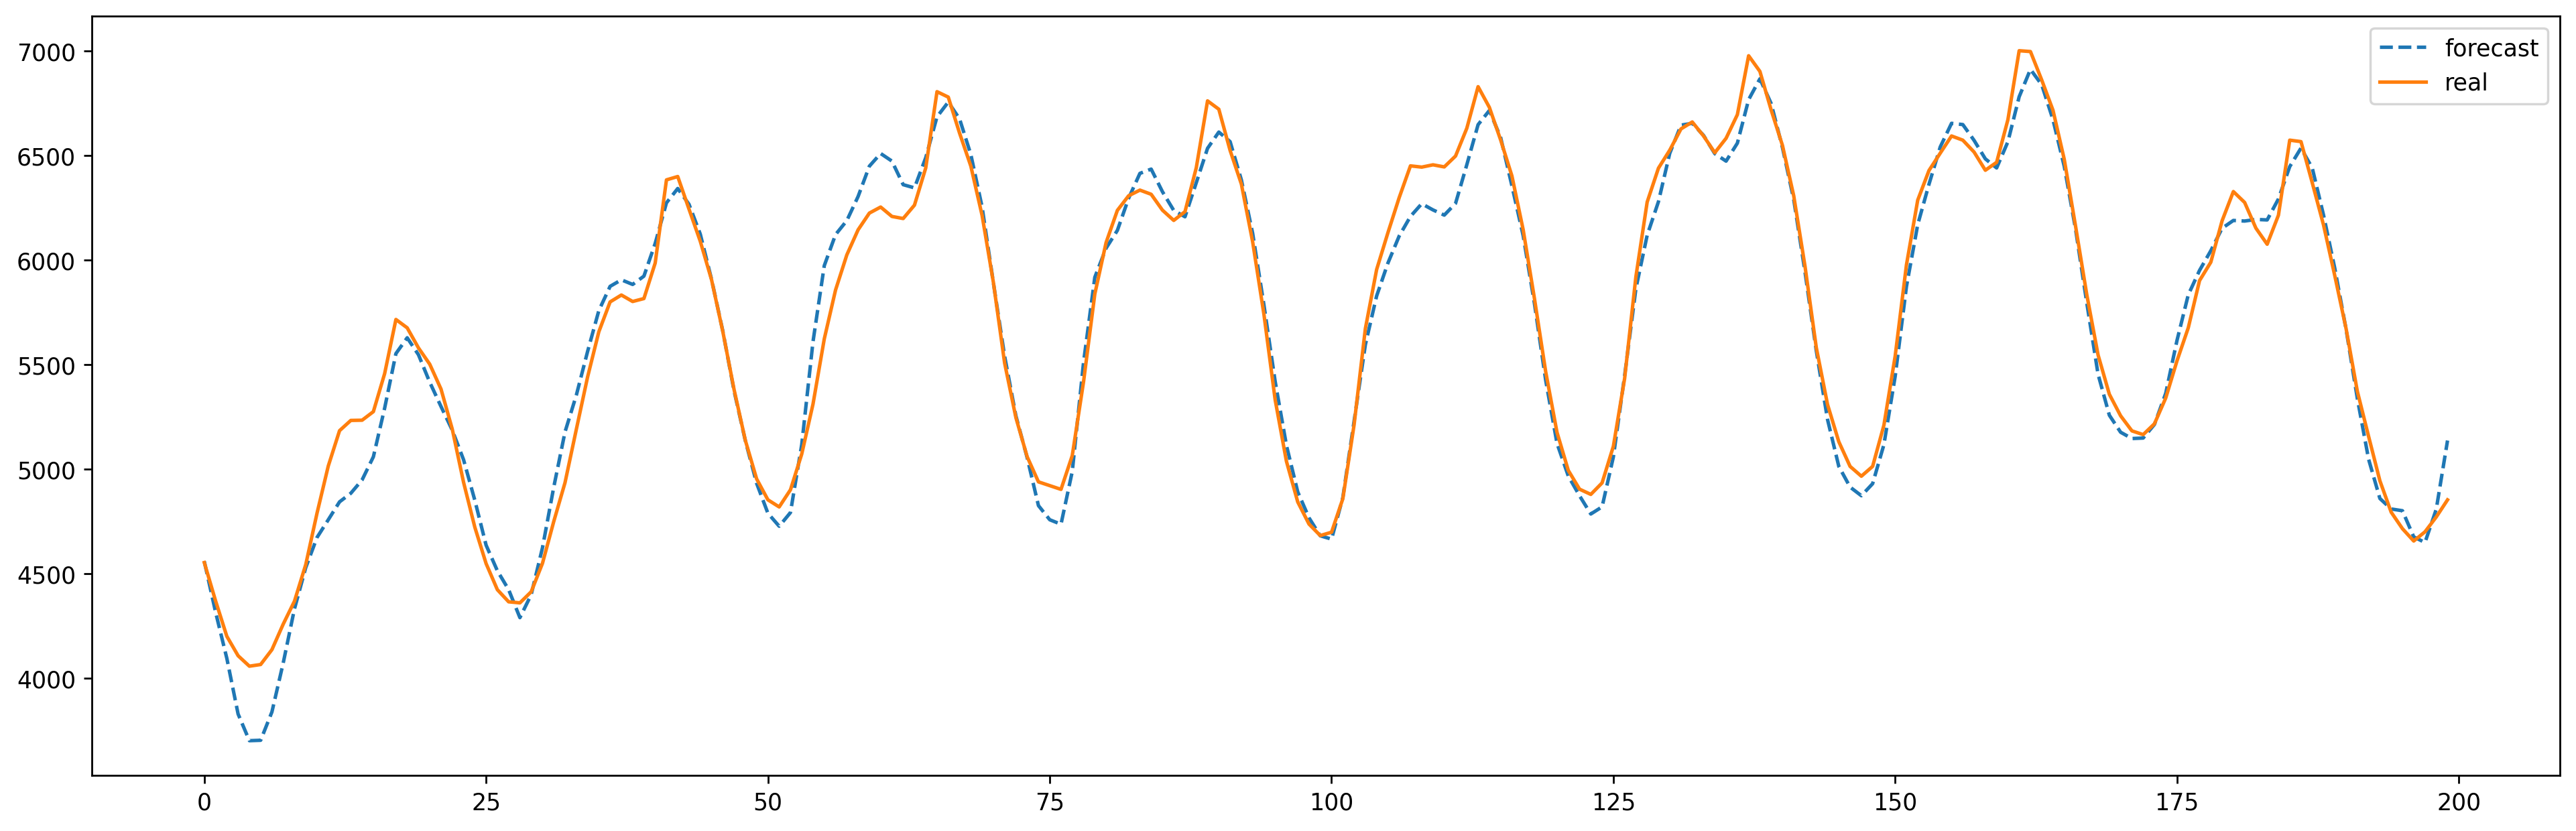

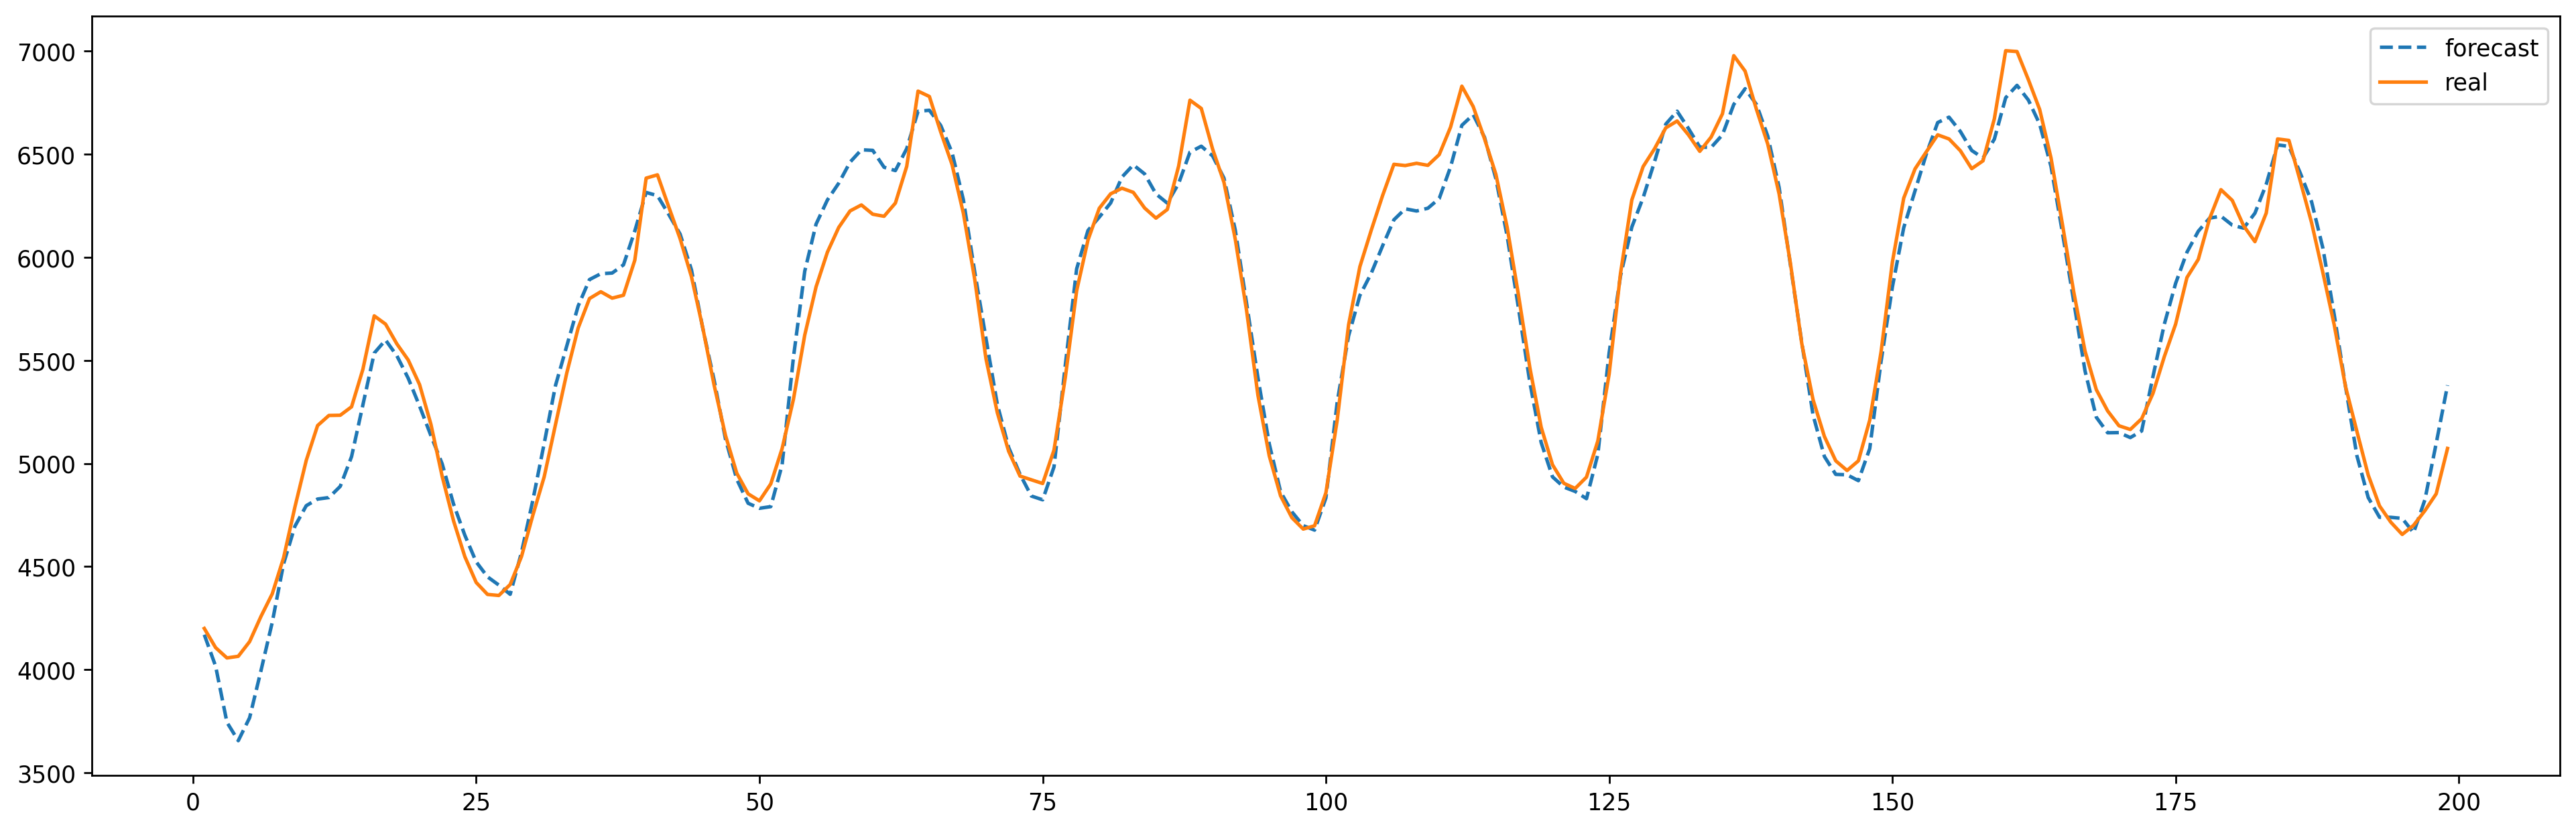

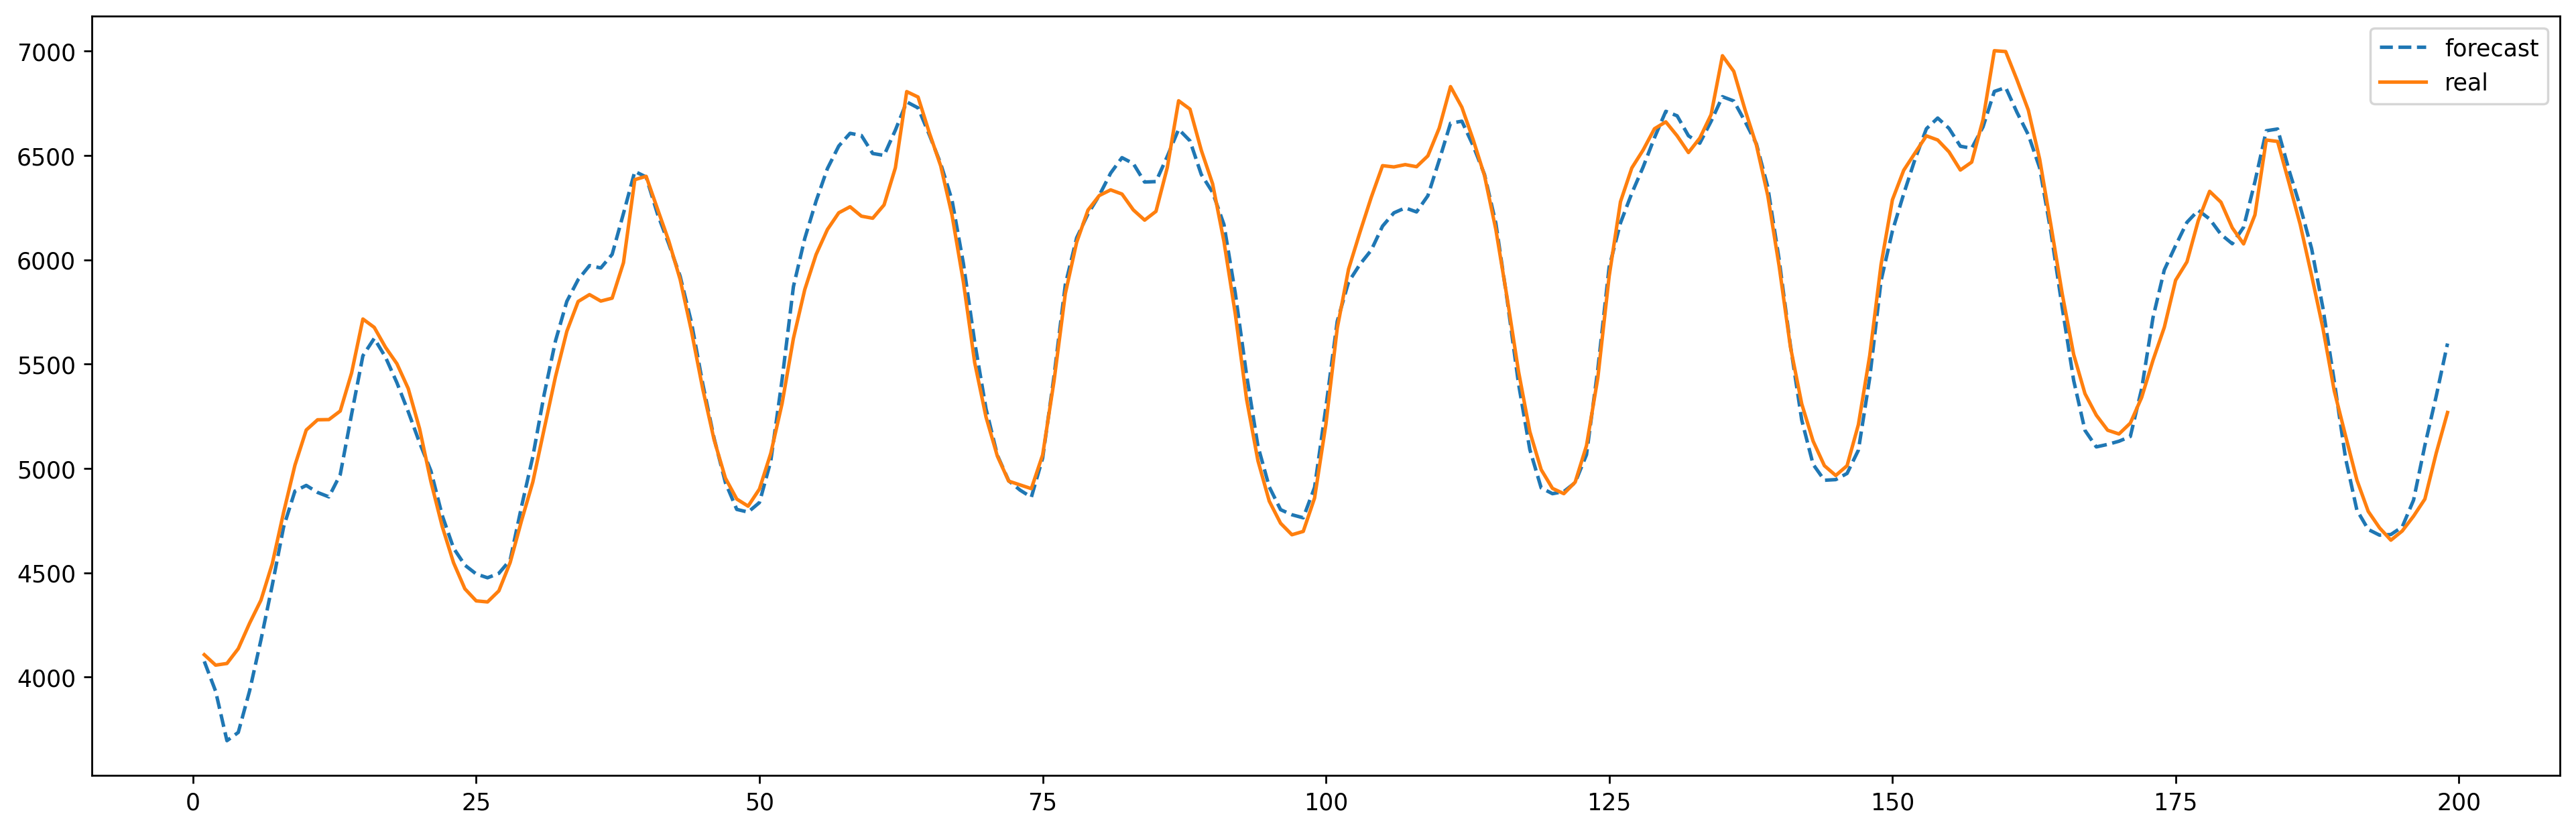

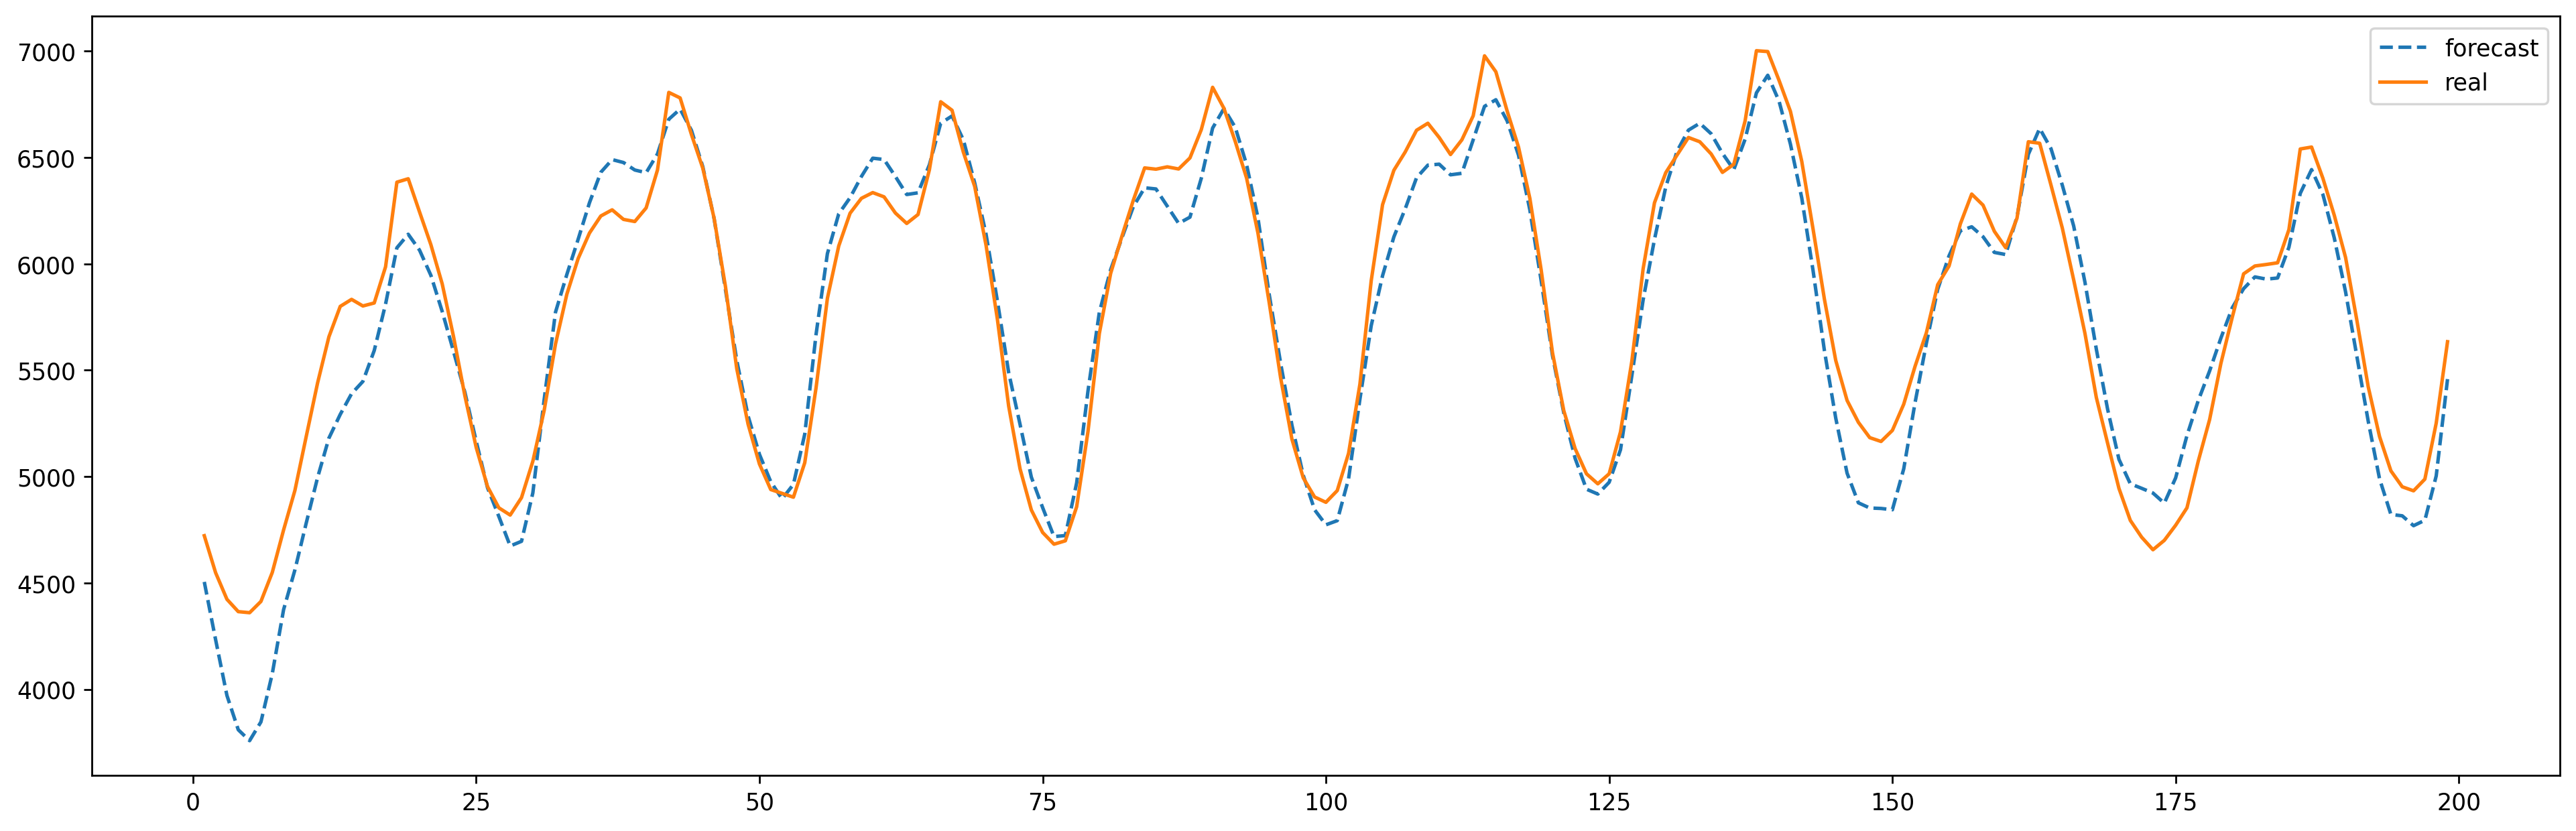

In [28]:
# create an empty dataframe  
df = pd.DataFrame()
df['forcasted_demand_1h'] = 0
df['forcasted_demand_2h'] = 0
df['forcasted_demand_3h'] = 0
df['forcasted_demand_24h'] = 0
df['real_demand_1h'] = 0
df['real_demand_2h'] = 0
df['real_demand_3h'] = 0
df['real_demand_24h'] = 0

for i in range(len(preds)):
    prediction_descaled=[]
    values_descaled=[]
    prediction_descaled = descale(descaler, preds[[i]].reshape(-1))
    values_descaled = descale(descaler, true[[i]].reshape(-1))
    new_row = {'forcasted_demand_1h':prediction_descaled[0], 
           'forcasted_demand_2h':prediction_descaled[1], 
           'forcasted_demand_3h':prediction_descaled[2],
           'forcasted_demand_24h':prediction_descaled[23],
           'real_demand_1h' : values_descaled[0],
           'real_demand_2h' : values_descaled[1],
           'real_demand_3h' : values_descaled[2],
           'real_demand_24h' : values_descaled[23]}
    
    df = df.append(new_row, ignore_index=True)

print('error for next 1 hour prediction')
error_1h = calculate_metrics(df.forcasted_demand_1h,df.real_demand_1h )
print("\n")
print('error for next 2 hour prediction')
error_2h = calculate_metrics(df.forcasted_demand_2h,df.real_demand_2h )
print("\n")
print('error for next 3 hour prediction')
error_3h = calculate_metrics(df.forcasted_demand_3h,df.real_demand_3h )
print("\n")
print('error for next 24 hour prediction')
error_24h = calculate_metrics(df.forcasted_demand_24h,df.real_demand_24h )
print("\n")



print('1-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_1h))
plt.plot(dates[0:200], df.forcasted_demand_1h[0:200], "--", label="forecast")
plt.plot(dates[0:200], df.real_demand_1h[0:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

print('2-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_1h))
plt.plot(dates[1:200], df.forcasted_demand_2h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_2h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

print('3-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_3h))
plt.plot(dates[1:200], df.forcasted_demand_3h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_3h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();


print('24-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_24h))
plt.plot(dates[1:200], df.forcasted_demand_24h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_24h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

Visualizing the series (the next 24-hour forecast for a specific day)

In [29]:
prediction_descaled=[]
values_descaled=[]
for i in range(len(preds)):
    prediction_descaled.append(descale(descaler, preds[[i]].reshape(-1)))
    values_descaled.append(descale(descaler, true[[i]].reshape(-1)))

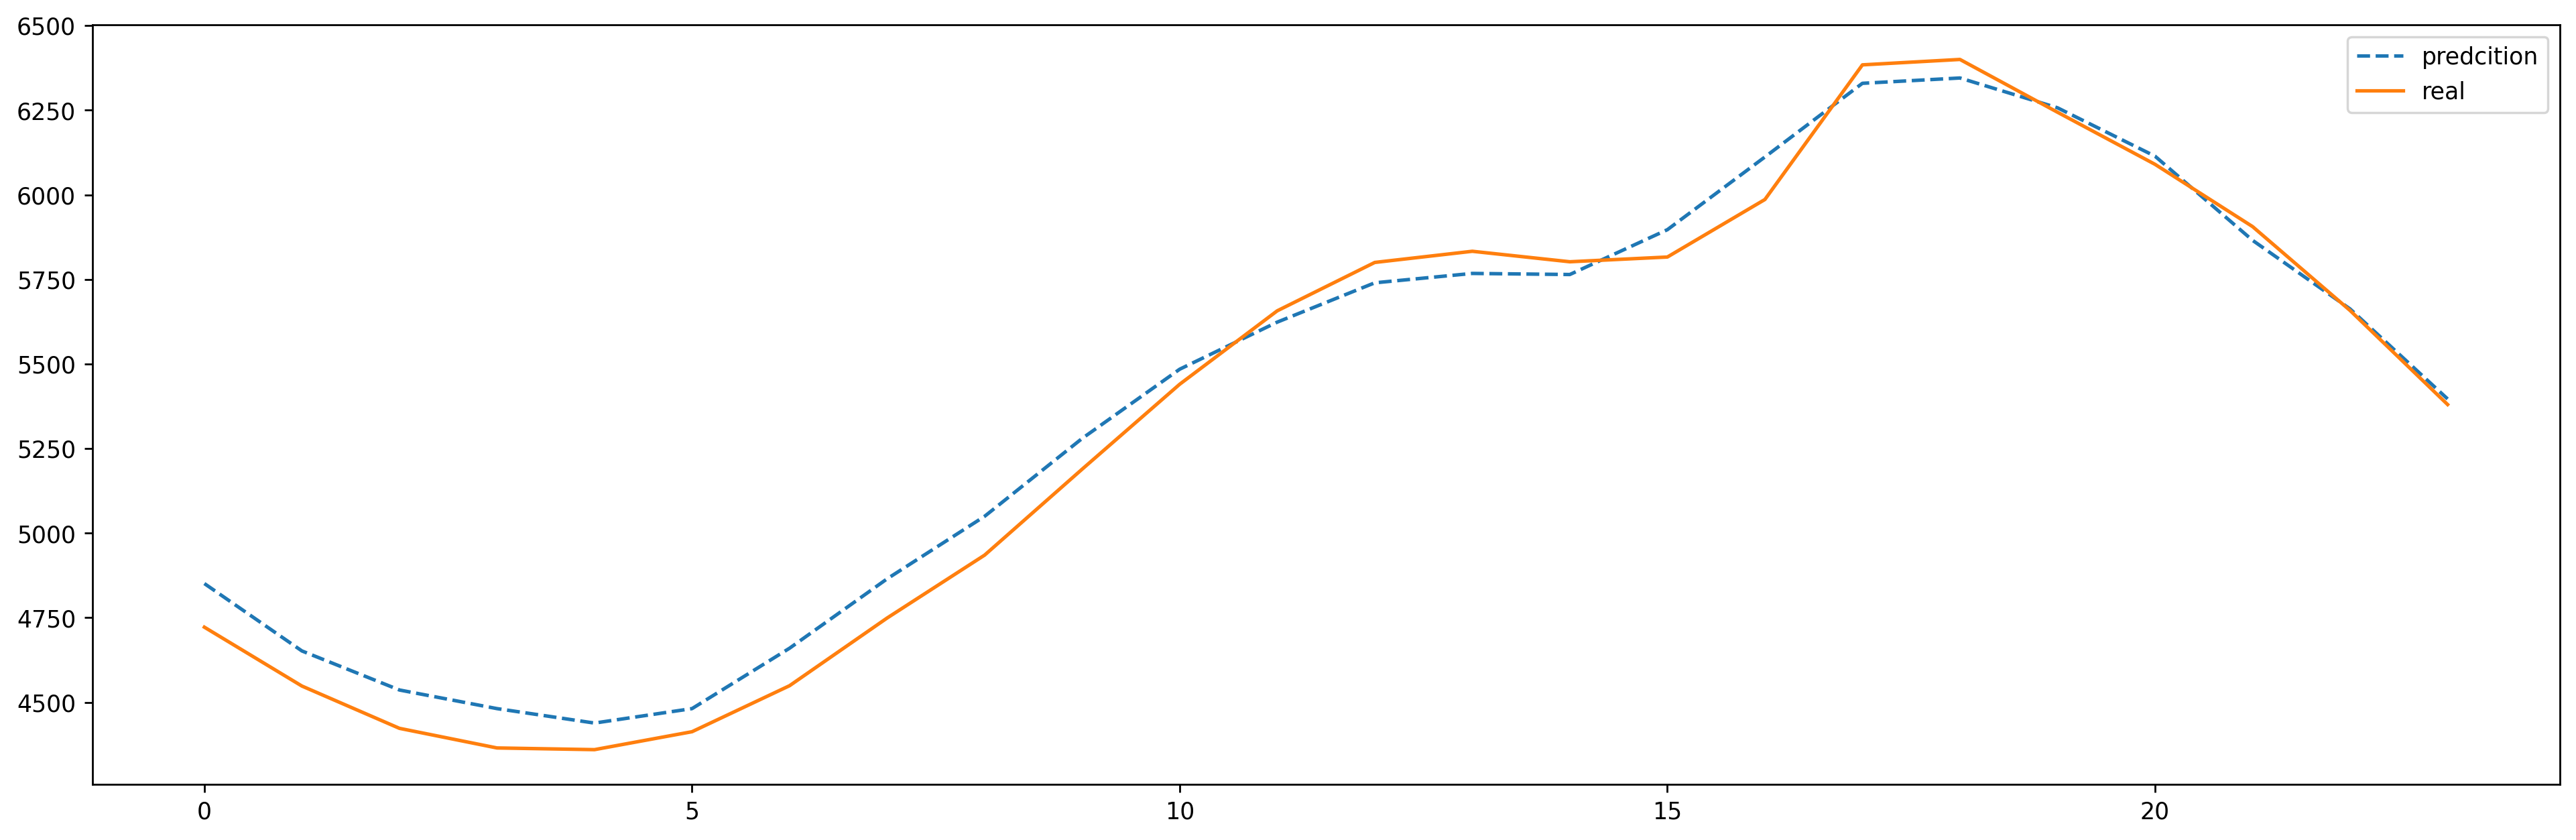

In [30]:
figure(figsize=(19, 6), dpi=250)

#select the day to forecast
day=1

dates = range(len(prediction_descaled))
plt.plot(dates[0:24], prediction_descaled[day*24] , "--", label="predcition")
plt.plot(dates[0:24], values_descaled[day*24], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();